In [3]:
from sklearn.cluster import KMeans
import pandas as pd

def format_feature_names(original, add_params=True):
    feat_names = []
    for feat_name in original:
        first = feat_name.replace('value__', '')
        second = first.split('__')
        feature = second[0]
        params = second[1:]

        if params and add_params:
            string = '('
            for param in params:
                var, value = param.rsplit('_', 1)
                string += f'{var}={value}, '
            string = string[:-2] + ')'
            feature += string
        feat_names.append(feature)
    return feat_names


classification_dir = f'../results/classification'

In [2]:
feature_importance_df = pd.read_csv(f'{classification_dir}/feature_importances_raw.csv')

original = feature_importance_df[feature_importance_df['downsampler'] == 'Original']
rest = feature_importance_df[feature_importance_df['downsampler'] != 'Original']

final = pd.DataFrame()

for downsampler in rest['downsampler'].unique():
    subset = rest[rest['downsampler'] == downsampler]
    temp = original.copy()
    temp['downsampler'] = downsampler
    combined = pd.concat([subset, temp])
    final = pd.concat([final, combined])

final

,feature_name,importance_impurity,downsampler,factor,fold
2549,sum_values,0.002276,Decimate,2,1
2550,abs_energy,0.004960,Decimate,2,1
2551,mean_abs_change,0.001719,Decimate,2,1
2552,mean,0.002220,Decimate,2,1
2553,standard_deviation,0.005895,Decimate,2,1
...,...,...,...,...,...
2544,"permutation_entropy(dimension=4, tau=1)",0.003035,MinMaxLTTB,1,10
2545,"permutation_entropy(dimension=5, tau=1)",0.003403,MinMaxLTTB,1,10
2546,"permutation_entropy(dimension=6, tau=1)",0.003339,MinMaxLTTB,1,10
2547,"permutation_entropy(dimension=7, tau=1)",0.003217,MinMaxLTTB,1,10


In [9]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

final = final[(final['factor'] <= 50) & (final['downsampler'].isin(['LTTB', 'Decimate', 'MinMax', 'M4']))]

final['feature_name'] = format_feature_names(final['feature_name'])

importance_metric = 'importance_permutation'

importance_summary = (
    final
    .groupby(['downsampler', 'factor', 'feature_name'])[importance_metric]
    .mean()
    .reset_index()
    .rename(columns={importance_metric: 'mean_importance'})
)

pivot_for_clustering = importance_summary.pivot_table(
    index='feature_name',
    columns=['downsampler', 'factor'],
    values='mean_importance'
).fillna(0)

scaler = StandardScaler()
scaled_features = scaler.fit_transform(pivot_for_clustering)

inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(scaled_features)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans_temp.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')

ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
plt.tight_layout()
plt.show()

KeyError: 'Column not found: importance_permutation'

clustering based on: importance_impurity
cluster 0 (146 features):
absolute_sum_of_changes, agg_autocorrelation(f_agg="mean", maxlag=40), agg_autocorrelation(f_agg="median", maxlag=40), agg_linear_trend(attr="intercept", chunk_len=10, f_agg="var"), agg_linear_trend(attr="intercept", chunk_len=5, f_agg="var"), agg_linear_trend(attr="intercept", chunk_len=50, f_agg="max"), agg_linear_trend(attr="intercept", chunk_len=50, f_agg="min"), agg_linear_trend(attr="intercept", chunk_len=50, f_agg="var"), agg_linear_trend(attr="slope", chunk_len=10, f_agg="var"), agg_linear_trend(attr="slope", chunk_len=5, f_agg="var")
Average importance: 0.002917
cluster 1 (35 features):
abs_energy, agg_autocorrelation(f_agg="var", maxlag=40), agg_linear_trend(attr="stderr", chunk_len=10, f_agg="max"), agg_linear_trend(attr="stderr", chunk_len=10, f_agg="min"), agg_linear_trend(attr="stderr", chunk_len=5, f_agg="max"), agg_linear_trend(attr="stderr", chunk_len=5, f_agg="min"), ar_coefficient(coeff=2, k=10), ar_c

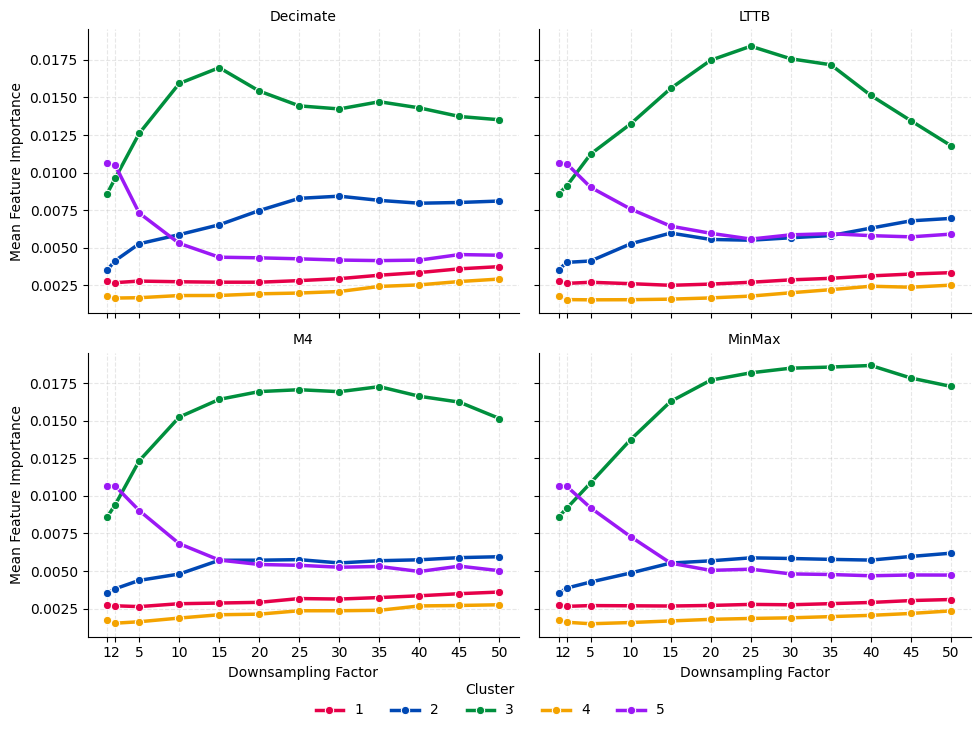

In [8]:
import numpy as np
import seaborn as sns

n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_features)

pivot_for_clustering['cluster'] = clusters

feature_cluster_map = pivot_for_clustering['cluster'].to_dict()
importance_summary['cluster'] = importance_summary['feature_name'].map(feature_cluster_map)

cluster_means = (
    importance_summary
    .groupby(['cluster', 'downsampler', 'factor'])['mean_importance']
    .mean()
    .reset_index()
)

cluster_means['cluster'] = cluster_means['cluster'] + 1

print(f"clustering based on: {importance_metric}")
for cluster_id in range(n_clusters):
    features_in_cluster = pivot_for_clustering[pivot_for_clustering['cluster'] == cluster_id].index.tolist()
    print(f"cluster {cluster_id} ({len(features_in_cluster)} features):")
    print(", ".join(features_in_cluster[:10]))
    cluster_avg_importance = (importance_summary[importance_summary['cluster'] == cluster_id]['mean_importance'].mean())
    print(f"Average importance: {cluster_avg_importance:.6f}")

cluster_stats = (
    importance_summary
    .groupby(['cluster', 'downsampler', 'factor'])['mean_importance']
    .agg(['mean', 'std', 'count'])
    .reset_index()
)
cluster_stats['se'] = cluster_stats['std'] / np.sqrt(cluster_stats['count'])

g = sns.FacetGrid(
    cluster_means,
    col="downsampler",
    col_wrap=2,
    height=3.5,
    aspect=0.9,
    sharey=True,
    sharex=True
)

CLUSTER_COLORS = [
    "#E60049",
    "#0048B4",
    "#008F3D",
    "#F4A300",
    "#9B19F5",
]

g.map_dataframe(
    sns.lineplot,
    x="factor",
    y="mean_importance",
    hue="cluster",
    marker='o',
    linewidth=2.5,
    markersize=6,
    palette=CLUSTER_COLORS
)
g.set_axis_labels("Downsampling Factor", "Mean Feature Importance")
g.set_titles(col_template="{col_name}")
g.add_legend(title='Cluster', loc='lower center', ncols=n_clusters, bbox_to_anchor=(0.5, -0.05))

for ax in g.axes.flat:
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_xticks(final['factor'].unique())
    
plt.tight_layout()
plt.show()